In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [2]:
# collect the credits, keywords, and movies data
# drop unnecessary data
# make sure each column has the correct data type
# combine all three files together for analysis, merge on id
# fill null values

credits = pd.read_csv('../Downloads/data/credits.csv')
keywords = pd.read_csv('../Downloads/data/keywords.csv')
movies = pd.read_csv('../Downloads/data/movies_metadata.csv').\
drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
drop([19730, 29503, 35587]) # incorrect data

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [3]:
# create function to parse data

def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

In [4]:
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [6]:
# cleaned and merged dataset for further processing
# let's take a look inside

df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [7]:
# check data types are correct and convert wrong ones into correct ones

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [8]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

(0.0, 2.0, 0.9, 1.2)

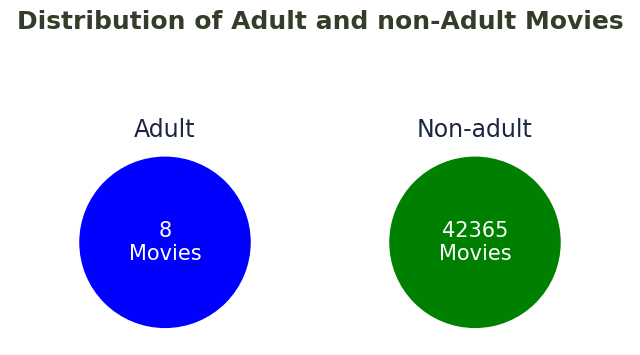

In [9]:
# Data Analysis and Visualization to gain intuition about data

plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['blue', 'green'])
plt.xlim(0,2)
plt.ylim(0.9, 1.2)

plt.title('Distribution of Adult and non-Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va = 'center', ha = 'center', fontsize=15, weight=500, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va = 'center', ha = 'center', fontsize=15, weight=500, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non-adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

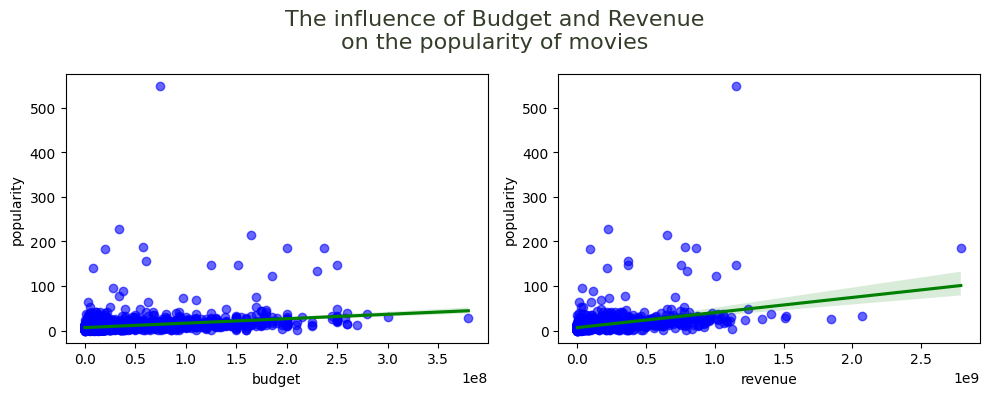

In [10]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

plt.suptitle('The influence of Budget and Revenue\non the popularity of movies', fontsize=16, weight=500, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity', scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "green"}, ax=axes[i])

plt.tight_layout()

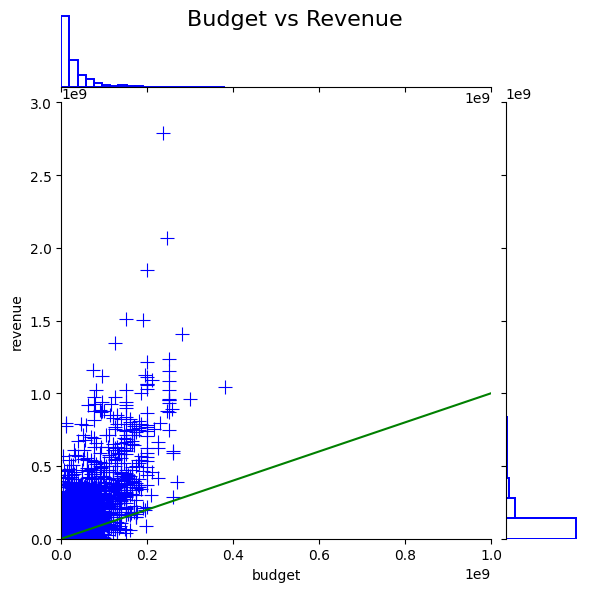

In [11]:
# Budget vs Revenue

ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x = 'budget', y = 'revenue', marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='blue')
ax.fig.suptitle('Budget vs Revenue', fontsize=16, weight=500, color='black')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='green')

(-1.25, 1.25, -1.25, 1.25)

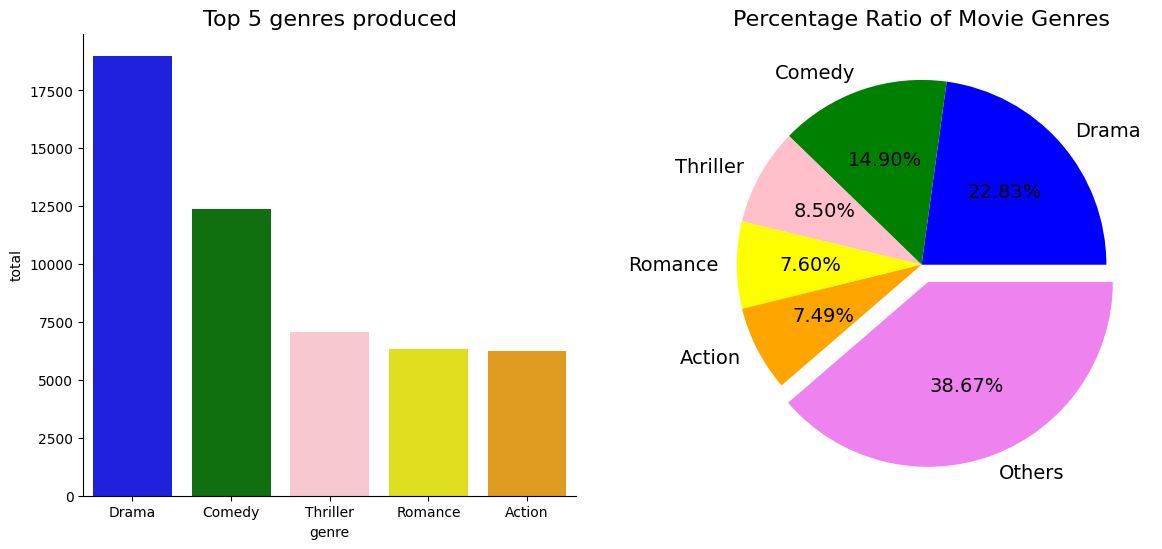

In [12]:
# Top 5 genres of movies in the dataset

genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['blue', 'green', 'pink', 'yellow', 'orange'])
ax.set_title('Top 5 genres produced', fontsize=16, weight=500, color='black')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total': df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=16, weight=500, color='black')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%', textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['blue', 'green', 'pink', 'yellow', 'orange', 'violet'])

axes[1].axis('off')

Text(0.5, 1.0, 'The relationship between rating and popularity')

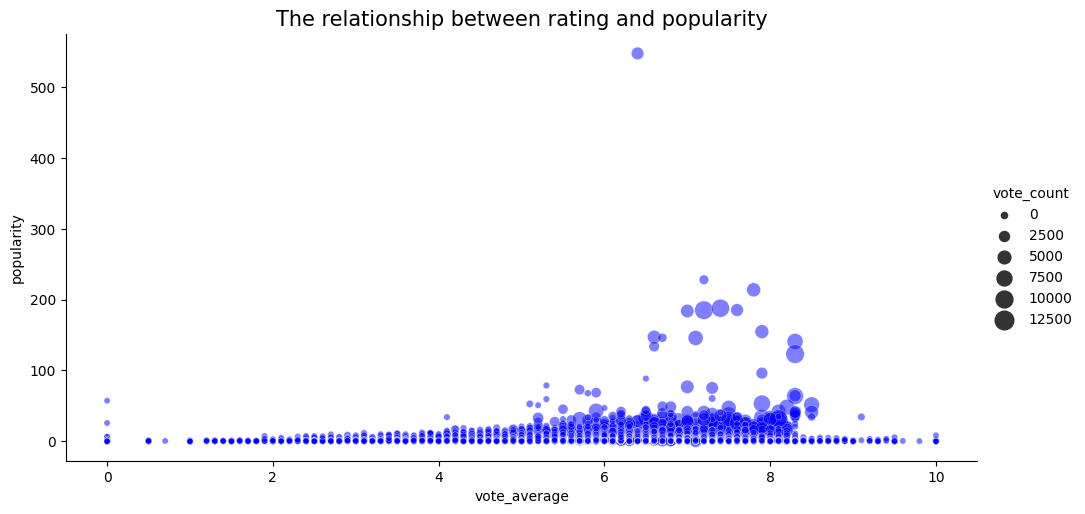

In [13]:
# Relationship between rating and popularity

sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count', sizes=(20,200), alpha=.5, aspect=2, color='blue')
plt.title('The relationship between rating and popularity', fontsize=15, weight=500, color='black')

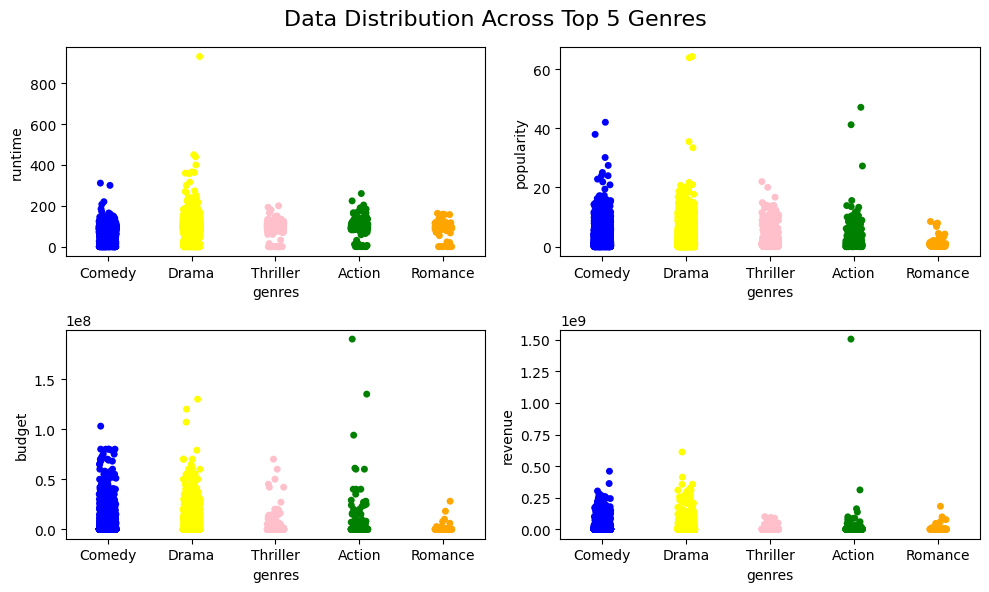

In [14]:
# Data distribution across top 5 genres

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=16, weight=500, color='black')

for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['blue', 'yellow', 'pink', 'green', 'orange'])

plt.tight_layout()

Hybrid recommender system:

with weighted average, you give a fair rating for each movie. For this particular one, we will also use bag of words method.

When you look at the dataset we had, there are many valuable information such as genre, overview, etc. We will be using this information to make our recommender system more robust by extracting the information inside bag of words, combined with weighted average to get the final similary for the movies

weighted average = (R * v) + (C * m) / v + m

* R = average rating for the movie (1-10)
* v = number of votes for the movie
* m = minimum votes required to be listed
* C = mean vote across the entire data

In [15]:
# recommender system

R = df['vote_average']
v = df['vote_count']
# we will only consider movies that have more votes than at least 80% of the movies in our data set
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = ((R * v) + (C * m))/(v + m)

In [17]:
# Feature scaling

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [18]:
# create score
# we'll be using 40% weight for weighted_average and 60% weight for popularity

weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [19]:
# once the score has been calculated, we can see each score here

weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


In [33]:
# create hybrid dataframe and further process data with bag of words method and cosine similarity
# to find similar movies with similar content by looking at the words

hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [34]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # remove text inside parentheses
        # replace '' with '', remove digits if found
        cleaned = cleaned.translate(str.maketrans('', '', string.digits)) 
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('', '', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('', '', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('', '', string.digits))
    return clean_text

In [35]:
hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)
hybrid_df['characters'] = hybrid_df['characters'].apply(separate)
hybrid_df['actors'] = hybrid_df['actors'].apply(separate)

hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()


,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


A common method to find similarity between 2 movies is a method called cosine similarity. Because of limited memory, we wil only take the first 10000 movies from weighted_df_sorted

In [36]:
# tf-idf (term frequency - inverse document frequency)
# indicates the importance of the word is in order to understand the document or dataset
# tf indicates the frequency of each of the words present in the document or dataset
# idf tells us how important the word is to the document

hybrid_df = weighted_df_sorted[:10000].merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [37]:
# cosine similarity is a metric used to measure the similarity of two vectors

cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [38]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T

    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)

    final_df['final_score'] = final_df['score']*(1 - similarity_weight) + final_df['similarity']*similarity_weight

    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)

    return final_df_sorted[['score', 'similarity', 'final_score']]

In [39]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.537320,0.471460
Toy Story 3,0.336500,0.274778,0.293295
Toy Story of Terror!,0.282269,0.294860,0.291082
Small Fry,0.256223,0.271028,0.266586
Hawaiian Vacation,0.266277,0.263819,0.264556
Minions,0.841413,0.005376,0.256187
Finding Nemo,0.346185,0.203631,0.246397
WALL·E,0.348682,0.196733,0.242317


In [40]:
predict('Star Wars', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Star Wars,0.396483,1.000000,0.818945
Rogue One: A Star Wars Story,0.345326,0.815941,0.674757
The Empire Strikes Back,0.377867,0.413723,0.402966
Star Wars: The Force Awakens,0.346711,0.260269,0.286201
Return of the Jedi,0.353032,0.245817,0.277982
Minions,0.841413,0.001336,0.253359
The Great Dictator,0.351636,0.192933,0.240544
Star Wars: Episode III - Revenge of the Sith,0.300342,0.186790,0.220855
Star Wars: Episode I - The Phantom Menace,0.258540,0.142167,0.177079


In [41]:
hybrid_df.to_csv('hybrid_df.csv')

In [42]:
import pickle
pickle.dump(tfidf_matrix, open('cosine_similarity.pkl', 'wb'))

#### TensorFlow Recommenders (TFRS)

we will use multi-objective approach that applies both implicit (movie watches) and explicit signals (ratings). In the end, we can predict what movies the user should watch along with the given rating based on historical data

In [43]:
# get data from ratings_small

ratings_df = pd.read_csv('../Downloads/data/ratings_small.csv')

# convert data type and change col from 'timestamp' to 'date'
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

# merge ratings_df with the original df we created earlier and clean df
ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId', right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-13 18:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-13 18:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-13 18:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-13 18:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-13 18:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [44]:
# create movies_df using movieId and title cols

movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [45]:
# create ratings and movies dataset

ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [47]:
# set seed and separate data into training and test set
# set seed so we can reproduce results

print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 43188


In [48]:
# separate into batches to process

movie_titles = movies.batch(1000)
user_ids = ratings.batch(1000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique Users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique Users: 671


In [49]:
class MovieModel(tfrs.models.Model):
    def __init__(self, rating_weight:float, retrieval_weight:float) -> None:
        # take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights
        super().__init__()
        embedding_dimension = 64

        # user and movie models
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None
            ),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])

        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None
            ),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])


        # a small model to take in user and movie embeddings and predict ratings
        self.rating_model= tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        # the task

        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.movie_model)
            )
        )

        # the loss weights
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # pick out the user features and pass them into the user model
        user_embeddings = self.user_model(features["userId"])
        # pick out the movie features and pass them into the movie mode 1
        movie_embeddings = self.movie_model(features["original_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # apply the multi-layered rating model to a concatenation of user and movie embeddings
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            )
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        ratings=features.pop("rating")

        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # compute the loss for each task
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

        # combine them using the loss weights
        return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

In [51]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1000).cache()
cached_test = test.batch(1000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 17s 435ms/step - root_mean_squared_error: 1.4584 - factorized_top_k/top_1_categorical_accuracy: 3.1429e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0189 - factorized_top_k/top_50_categorical_accuracy: 0.1013 - factorized_top_k/top_100_categorical_accuracy: 0.1684 - loss: 6816.7621 - regularization_loss: 0.0000e+00 - total_loss: 6816.7621
Epoch 2/3
35/35 [==============================] - 15s 426ms/step - root_mean_squared_error: 1.0127 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0201 - factorized_top_k/top_10_categorical_accuracy: 0.0445 - factorized_top_k/top_50_categorical_accuracy: 0.2038 - factorized_top_k/top_100_categorical_accuracy: 0.3193 - loss: 6454.7248 - regularization_loss: 0.0000e+00 - total_loss: 6454.7248
Epoch 3/3
35/35 [==============================] - 24s 690ms/step - root_mean_squared_error: 1.0

In [53]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

9/9 [==============================] - 3s 300ms/step - root_mean_squared_error: 1.2110 - factorized_top_k/top_1_categorical_accuracy: 2.4426e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0042 - factorized_top_k/top_10_categorical_accuracy: 0.0093 - factorized_top_k/top_50_categorical_accuracy: 0.0480 - factorized_top_k/top_100_categorical_accuracy: 0.0883 - loss: 5727.6762 - regularization_loss: 0.0000e+00 - total_loss: 5727.6762

Retrieval top-100 accuracy: 0.088
Ranking RMSE: 1.211


In [60]:
def predict_movie(user, top_n=3):
    # create a model that takes in raw query feat user
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

    # recommends movies out of the entire movies dataset
    index.index_from_dataset(
        tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # get recommendations
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i + 1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
        "userId": np.array([str(user)]),
        "original_title": np.array([movie])
    })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [65]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. The Greatest Story Ever Told
2. Un long dimanche de fiançailles
3. Scary Movie
4. Anatomie de l'enfer
5. El otro lado de la cama


In [66]:
predict_rating(123, 'Minions')

Predicted rating for Minions: 2.7090835571289062


let's examine <b>user 123</b> from historical data

In [67]:
ratings_df[ratings_df['userId']== '123']

,userId,movieId,rating,date,original_title,genres,overview
8053,123,233,4.0,2001-07-01 13:57:06,The Wanderers,Drama,The streets of the Bronx are owned by 60’s you...
8054,123,288,5.0,2001-07-01 12:32:47,High Noon,Western,High Noon is about a recently freed leader of ...
8055,123,407,5.0,2001-07-01 13:57:57,Kurz und schmerzlos,"Drama, Thriller",Three friends get caught in a life of major cr...
8056,123,968,3.0,2001-07-01 13:59:01,Dog Day Afternoon,"Crime, Drama, Thriller",A man robs a bank to pay for his lover's opera...
8057,123,1968,4.0,2001-07-01 12:30:36,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...
8058,123,1976,4.0,2001-07-01 12:31:51,Jezebel,"Drama, Romance","In 1850s Louisiana, the willfulness of a tempe..."
8059,123,2003,4.0,2001-07-01 12:31:51,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
8060,123,2428,5.0,2001-07-01 13:57:06,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
8061,123,2502,5.0,2001-07-01 13:59:01,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...
8062,123,2762,5.0,2001-07-01 13:59:54,Young and Innocent,"Drama, Crime",Derrick De Marney finds himself in a 39 Steps ...


In [69]:
# get metadata for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends movies out of the entire movies dataset
index.index_from_dataset(
    tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# get recommendations
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title':[i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
2,Un long dimanche de fiançailles,Drama,"In 1919, Mathilde was 19 years old. Two years ..."
3,Scary Movie,Comedy,Following on the heels of popular teen-scream ...
4,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
5,El otro lado de la cama,"Romance, Drama","When Paula leaves her mate Pedro, he misses he..."
